# Metadata

```yaml
Course:    DS 5001
Module:    09 Lab
Topic:     Word2Vec
Author:    R.C. Alvarado
Date:      28 March 2023 (revised)
```

**Purpose:** We create word embeddings with novel data using word2vec and visualize results with tSNE.

# Set Up

In [1]:
data_in = '../data/novels'
data_out = '../data/novels'
data_prefix = 'novels'

In [2]:
OHCO = ['book', 'chapter', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:4] # Paragraphs
SENT = OHCO[:5] # Sentences
BAG = PARA
# BAG = SENT

In [3]:
# word2vec parameters
w2v_params = dict(
    window = 5,
    size = 246,
    min_count = 50,
    workers = 4
)

In [4]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly_express as px

# Import `TOKENS` and convert to `DOCS` for Gensim

We import data from the TOKEN table of the novels corpus, excluding proper nouns.

In [5]:
TOKENS = pd.read_csv('{}/{}-TOKENS.csv'.format(data_in, data_prefix)).set_index(OHCO)

In [6]:
VOCAB = pd.read_csv('{}/{}-VOCAB.csv'.format(data_in, data_prefix))

In [7]:
TOKENS.head()

pos     term_str  term_id
book            chapter para_num sent_num token_num                           
secretadversary 1       0        1        0           DT          the    24127
                                          1          NNP        young    27354
                                          2          NNP  adventurers      399
                                          3          NNP          ltd    14406
                        1        0        0           JJ        tommy    24529

In [8]:
DOCS = TOKENS[~TOKENS.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
DOCS = [doc for doc in DOCS if len(doc) > 1] # Lose single word docs

In [57]:
# DOCS

# Generate word embeddings with Gensim's library

In [10]:
model = word2vec.Word2Vec(DOCS, **w2v_params)

# Visualize with tSNE

## Get model coordinates to plot

In [11]:
coords = pd.DataFrame(
    dict(
        vector = [model.wv.get_vector(w) for w in model.wv.vocab], 
        term_str = model.wv.vocab.keys()
    )).set_index('term_str')

In [61]:
# coords

In [12]:
# TFM = coords.apply(lambda x: pd.Series(x.vector), 1)

## Use ScikitLearn's TSNE library

In [13]:
tsne_engine = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model = tsne_engine.fit_transform(coords.vector.to_list())

/Users/rca2t1/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/rca2t1/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [14]:
coords['x'] = tsne_model[:,0]
coords['y'] = tsne_model[:,1]

## Add some vocab features 

In [15]:
if coords.shape[1] == 3:
    coords = coords.merge(VOCAB.reset_index(), on='term_str')
    coords = coords.set_index('term_str')

In [16]:
coords = coords[coords.stop == 0]

In [17]:
# coords.head()

## Plot the coordinates

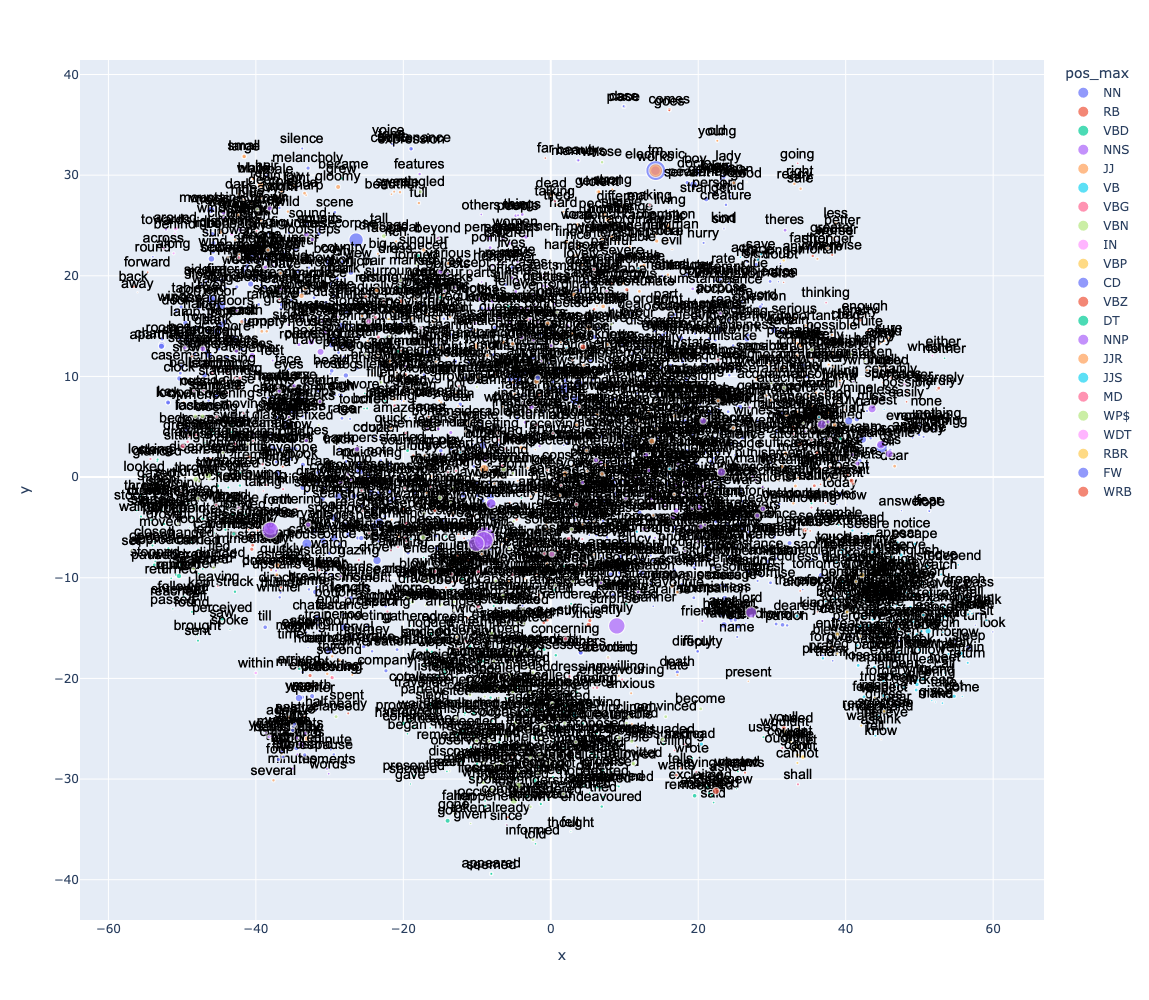

In [18]:
px.scatter(coords.reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_max', 
           hover_name='term_str',          
           size='tfidf_max',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Semantic Algebra

## Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [19]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [20]:
complete_analogy('man', 'boy', 'woman', 3)

term       sim
0     girl  0.759098
1  peasant  0.740800
2     lady  0.719932

In [21]:
complete_analogy('girl', 'daughter', 'boy', 3)

term       sim
0       wife  0.803840
1    prayers  0.777035
2  companion  0.775506

In [22]:
complete_analogy('girl', 'sister', 'boy', 3)

term       sim
0    cousin  0.817963
1      wife  0.800549
2  mistress  0.785660

In [49]:
complete_analogy('man', 'gentleman', 'woman', 5)

term       sim
0     girl  0.812943
1    young  0.745729
2   fellow  0.739091
3  peasant  0.735462
4     lady  0.733034

In [50]:
complete_analogy('man', 'woman', 'gentleman', 5)

term       sim
0     girl  0.812943
1    young  0.745729
2   fellow  0.739091
3  peasant  0.735462
4     lady  0.733034

In [51]:
complete_analogy('woman', 'man', 'lady', 5)

term       sim
0  gentleman  0.723957
1        boy  0.719476
2     friend  0.706151
3     doctor  0.704008
4       girl  0.681029

In [52]:
complete_analogy('day', 'night', 'sun', 5)

term       sim
0    snow  0.829192
1   gates  0.827928
2  clouds  0.822250
3    rain  0.818092
4    wind  0.811247

## Similarites

In [53]:
get_most_similar('joy')

term       sim
0   admiration  0.894565
1       horror  0.888908
2      disgust  0.878212
3      delight  0.874370
4       sorrow  0.861674
5       tender  0.861525
6        grief  0.853797
7  indignation  0.851567
8       terror  0.849197
9      anguish  0.843644

In [54]:
get_most_similar('man')

term       sim
0  gentleman  0.872738
1      woman  0.835362
2       girl  0.772870
3     fellow  0.762891
4   creature  0.739658
5     person  0.708096
6   stranger  0.675986
7    peasant  0.661358
8       lady  0.650974
9        boy  0.618596

In [55]:
get_most_similar(positive=['man'], negative=['woman'])

term       sim
0       off  0.392097
1      down  0.343723
2        us  0.341917
3      away  0.341394
4      case  0.327614
5      here  0.322643
6        up  0.320303
7      back  0.315570
8       out  0.311931
9  together  0.310825

In [29]:
get_most_similar(positive='woman')

term       sim
0       girl  0.850109
1  gentleman  0.848333
2        man  0.835362
3   creature  0.797309
4     fellow  0.781503
5   stranger  0.751957
6    peasant  0.735446
7      child  0.734058
8       lady  0.704495
9   handsome  0.686443

In [30]:
get_most_similar(positive=['woman'], negative=['man'])

term       sim
0         sweet  0.531245
1       shocked  0.490290
2  particularly  0.490217
3      affected  0.484671
4     suffering  0.466971
5       beloved  0.465820
6        lively  0.465746
7      sensible  0.452952
8  affectionate  0.451788
9         dying  0.449153

In [31]:
get_most_similar(['man','woman'],['boy','girl'])

term       sim
0      human  0.520679
1        nor  0.500556
2       even  0.496908
3       real  0.448231
4       less  0.421358
5  possessed  0.420197
6       such  0.413463
7    natural  0.397340
8  suspected  0.392137
9     nature  0.390895

# Save

In [32]:
W2V = pd.DataFrame(model.wv.vectors_norm, index=model.wv.vocab.keys())
W2V.to_csv('{}/{}-W2V.csv'.format(data_out, data_prefix))
pd.Series(DOCS).to_csv('{}/{}-GENSIM_DOCS.csv'.format(data_out, data_prefix), index=False, header=False)

# View with HAC

In [33]:
proper_nouns = 'tommy emily tuppence agnes edmund holmes'.split()
coords2 = coords.loc[~coords.index.isin(proper_nouns), ['vector','stop','tfidf_sum','pos_max']]

In [34]:
coords2

vector  stop  \
term_str                                                              
woman       [0.034418683, -0.27161947, -0.46958542, 0.4624...     0   
seldom      [-0.075303644, 0.056364425, -0.16958547, -0.31...     0   
heard       [0.30340597, -1.2905961, -0.9577435, -0.819959...     0   
mention     [0.25892285, -0.39131805, -0.10619905, 0.22209...     0   
name        [0.48411024, -0.64979833, -0.5632562, -0.44876...     0   
...                                                       ...   ...   
strychnine  [-0.09851259, -0.220066, -0.052334078, -0.1321...     0   
chateau     [-0.12016767, -0.6663073, 0.051565506, -0.4706...     0   
abbess      [0.024324395, -0.0054654097, -0.13688381, 0.00...     0   
maamselle   [0.26048598, -0.247025, -0.029252928, 0.128592...     0   
rampart     [-0.16194494, -0.37845686, 0.1326901, -0.22207...     0   

             tfidf_sum pos_max  
term_str                        
woman       130.510553      NN  
seldom       60.584455      RB  
heard       102.784109     VBD  
mention      87.269351      NN  
name        100.359706      NN  
...                ...     ...  
strychnine  102.949290      NN  
chateau     242.192647      NN  
abbess       98.391843      NN  
maamselle   244.693403      NN  
rampart      74.746207      NN  

[2254 rows x 4 columns]

In [35]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

def hca(sims, labels, linkage_method='ward', color_thresh=.3):
    tree = sch.linkage(sims, method=linkage_method)
    fig_height = len(labels) / 3
    plt.figure()
    fig, axes = plt.subplots(figsize=(10, fig_height))
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

def plot_terms_tree(coords, terms_n = 100, term_pos_pat = r'^(N|V)', color_thresh=1):
    term_filter = coords.pos_max.str.match(term_pos_pat) & (coords.stop == 0) & (coords.index.str.len() > 2)
    M = coords[term_filter].sort_values('tfidf_sum', ascending=False).vector.head(terms_n)
    IDX = coords.loc[M.index].index #term_str
    hca(M.to_list(), IDX.to_list(), color_thresh=color_thresh)

<Figure size 640x480 with 0 Axes>

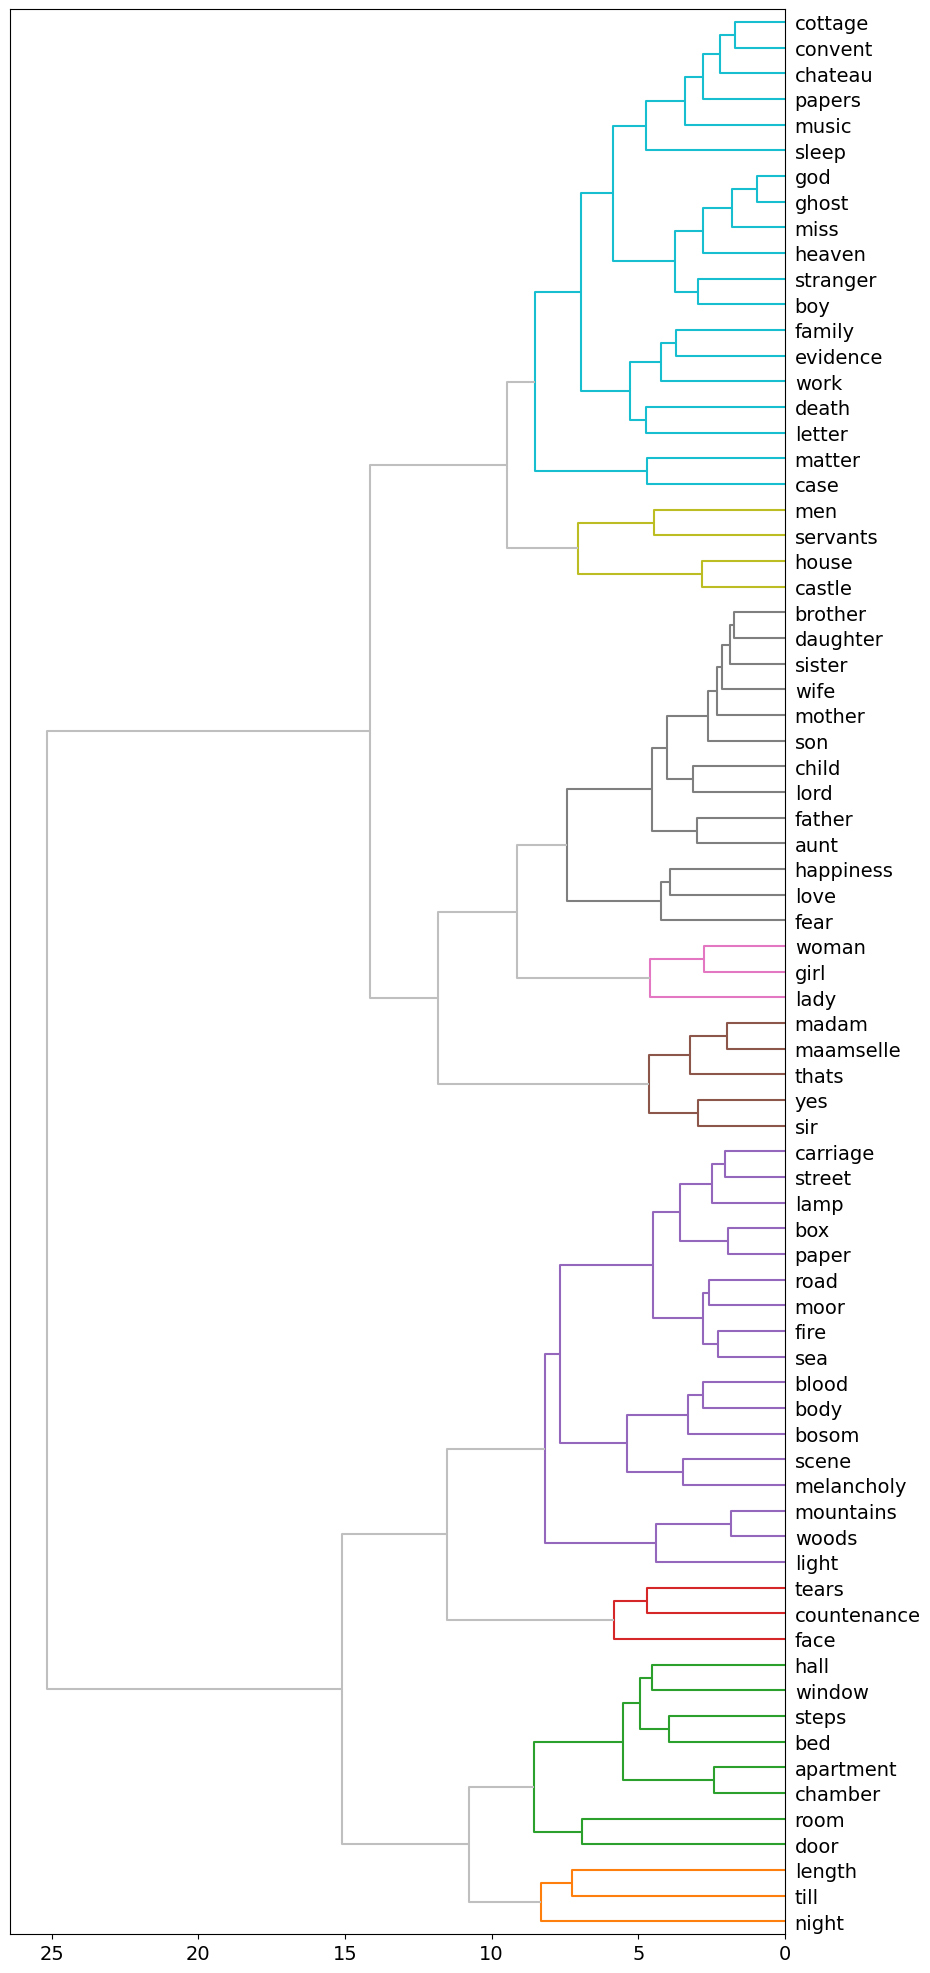

In [36]:
plot_terms_tree(coords2, term_pos_pat=r'^NN[^P]?', color_thresh=9, terms_n=75)

<Figure size 640x480 with 0 Axes>

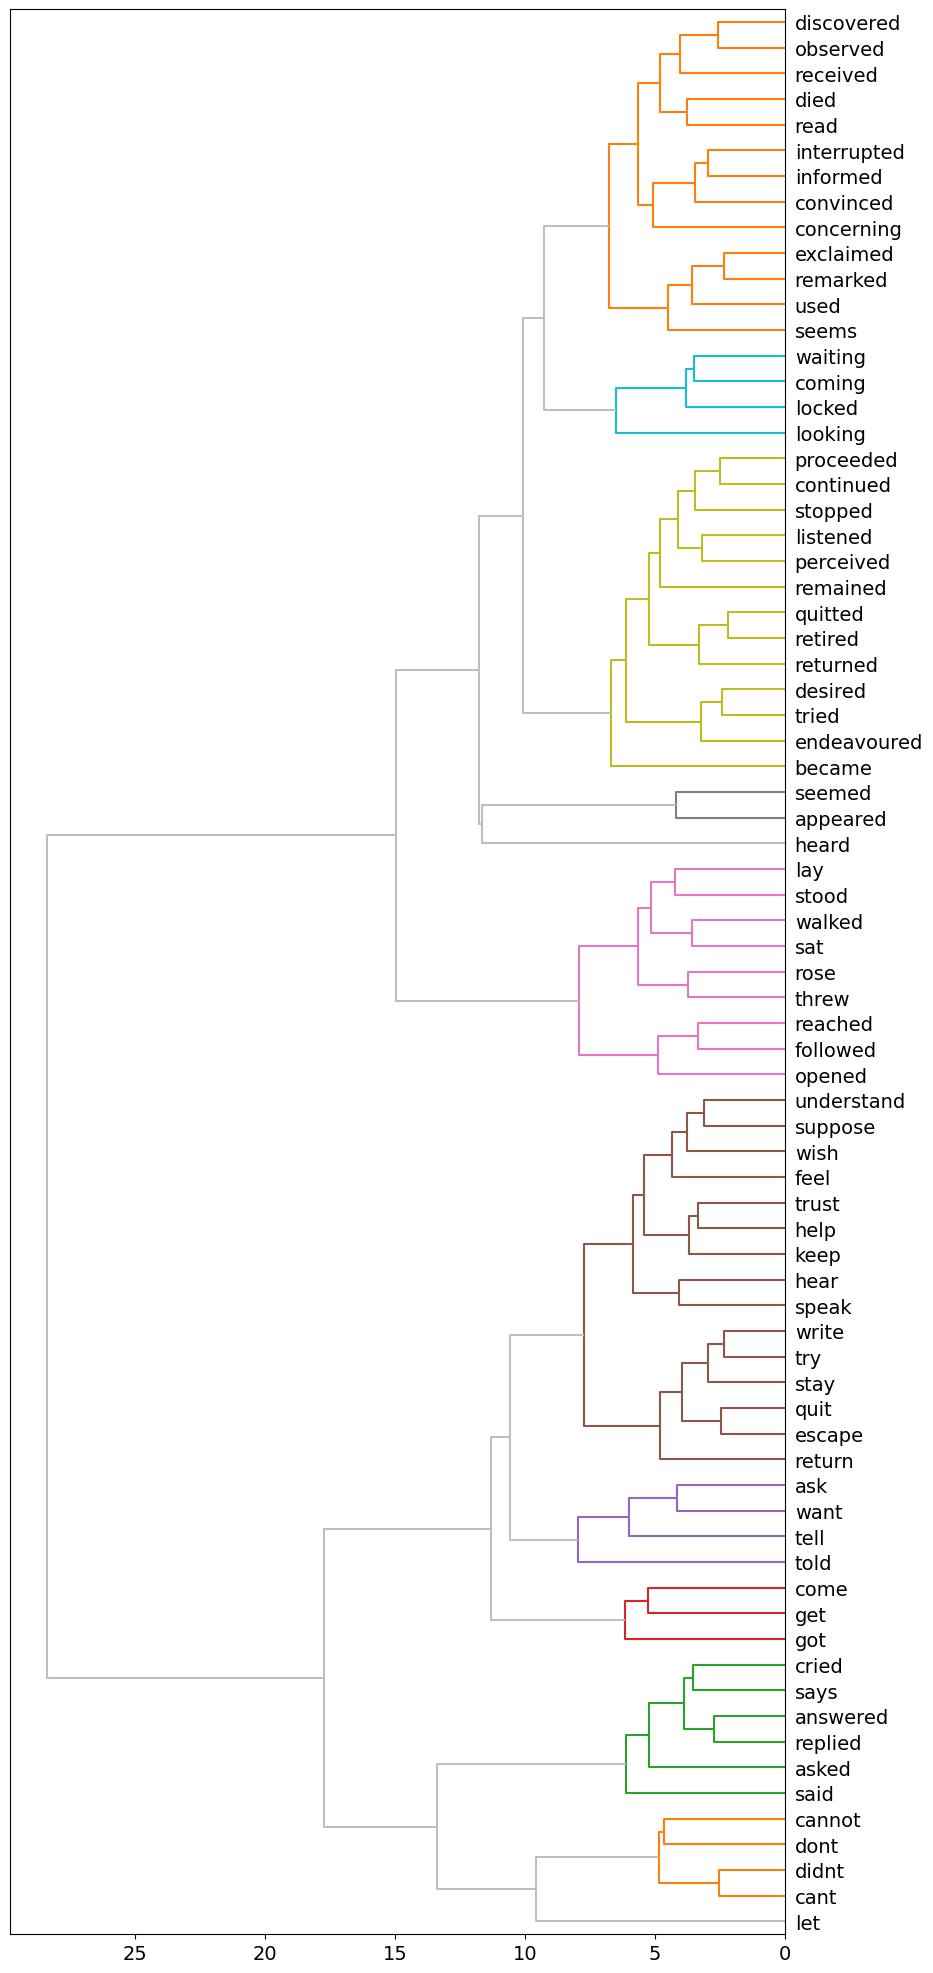

In [37]:
plot_terms_tree(coords2, term_pos_pat=r'^V', color_thresh=8, terms_n=75)

In [38]:
complete_analogy('woman','answered','man', 5)

term       sim
0     said  0.713781
1  replied  0.699853
2    added  0.694747
3    cried  0.692186
4     says  0.677458

In [39]:
complete_analogy('man','replied','woman', 5)

term       sim
0  exclaimed  0.745860
1   answered  0.739501
2     thinks  0.739438
3       said  0.695691
4      added  0.690057

In [40]:
complete_analogy('wife', 'appeared', 'husband', 5)

term       sim
0      seemed  0.805204
1  considered  0.649735
2      became  0.608331
3        felt  0.587191
4      sought  0.577080

In [41]:
complete_analogy('husband', 'appeared', 'wife', 5)

term       sim
0         seemed  0.687828
1  distinguished  0.631743
2      perceived  0.624914
3      concluded  0.610246
4      succeeded  0.591409

In [42]:
complete_analogy('man', 'father', 'woman', 5)

term       sim
0   mother  0.851358
1  husband  0.830300
2   sister  0.817570
3    niece  0.814635
4     aunt  0.806224

In [43]:
complete_analogy('man', 'husband', 'woman', 5)

term       sim
0  mother  0.842553
1   niece  0.838838
2  father  0.806216
3  sister  0.789075
4    aunt  0.787439

In [44]:
complete_analogy('man', 'castle', 'woman', 5)

term       sim
0        chateau  0.742940
1          house  0.739325
2        convent  0.734709
3  neighbourhood  0.728224
4        village  0.699416

In [45]:
complete_analogy('woman', 'home', 'man', 5)

term       sim
0    away  0.676822
1     off  0.667036
2    back  0.661992
3    rest  0.611339
4  dinner  0.606587